In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import h5py
from distancias import *
import os
from os.path import join
import scipy.io
from scipy.interpolate import PchipInterpolator
from scipy.signal.windows import tukey
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap #pip install umap-learn
import umap.plot
import hdbscan
from scipy.spatial.distance import cdist
from tqdm import tqdm
from sklearn.decomposition import PCA
import pywt
from scipy import stats

C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
def waveclus(spikes, n_features=10):
    n_spikes = spikes.shape[0]

    
    c = pywt.wavedec(spikes[0, :], 'haar', level=4)
    coeffs= np.concatenate((c[0], c[1], c[2], c[3], c[4]))
    
    CoefsWL = np.zeros((n_spikes, len(coeffs)))
    for ii in range(n_spikes):
        C = pywt.wavedec(spikes[ii,:], 'haar', level=4)
        CoefsWL[ii,:] = np.concatenate((C[0], C[1], C[2], C[3], C[4]))
    Features = CoefsWL.copy()
    DimFeatures= np.shape(Features)[1]

    Ptest= np.zeros(DimFeatures)
    KSstat= np.zeros(DimFeatures)
    
    for ii in range(DimFeatures):
        pd =stats.norm.fit(Features[:,ii])  #Estima parametros mu y sigma de los datos, 
                                            #ajustandolos a la distribucion normal
        mu = pd[0]
        sigma = pd[1]
        if sigma != 0:  
            Data= (Features[:,ii]- mu)/ sigma  #Normalizacion Z-score
            KSstat[ii], Ptest[ii]= stats.kstest(Data, 'norm')  #KS test
            
        else:
            KSstat[ii], Ptest[ii]= np.zeros(1, dtype="float"), np.zeros(1, dtype='float')
            
    #Ordenamos (el menos normal va ultimo)
    OrderIndex = np.argsort(KSstat)
        
    spike_features = np.zeros((n_spikes, n_features))
    
    for ii in range(n_features):
        index= OrderIndex[DimFeatures - 1 - ii]  #index = OrderIndex(DimFeatures +1-ii);
        spike_features[:,ii] = Features[:, index]
    sf = spike_features.copy()
    return sf

In [3]:
def extractor(archivo_espigas, archivos_señales, tamaño_onda=30, threshold=None):
    ondasxespigaxelectrodo = []
    t_espigas = []
    with h5py.File(archivo_espigas, "r") as f:
        for i in range(len(f["spiketimes"])):
            señal = archivos_señales[i]
            tiempos_espigas = np.array(f["spiketimes"]["elec_" + str(i)])
            ondasxespiga = np.zeros((len(tiempos_espigas), 2*tamaño_onda+1))
            for j, k in enumerate(tiempos_espigas):
                ondasxespiga[j]=señal[int(k-tamaño_onda):int(k+tamaño_onda+1)]
            if threshold is not None:
                maximos = ondasxespiga[:, tamaño_onda]
                primer_tiempo = ondasxespiga[:, 0]
                ultimo_tiempo = ondasxespiga[:, -1]
                no_espigas = np.where((maximos<threshold[1]) | (primer_tiempo<=threshold[0]) | (ultimo_tiempo<=threshold[0] | (maximos>threshold[2])))[0]
                ondasxespigaxelectrodo.append(np.delete(ondasxespiga, no_espigas, 0))
                t_espigas.append(np.delete(tiempos_espigas, no_espigas))
            else:
                ondasxespigaxelectrodo.append(ondasxespiga)
    if threshold is not None:
        return t_espigas, ondasxespigaxelectrodo
    else:
        return ondasxespigaxelectrodo

In [4]:
def spike_aligner(
    spikes,
    upsample_rate=6,
    alignment="tukey",
    window_length=24,
    min_sample=7,
    alpha=0.35,
):
    n_sample_points = np.shape(spikes)[1]
    sample_points = np.arange(n_sample_points)
    dense_sample_points = np.arange(0, n_sample_points, 1 / upsample_rate)

    interpolator = PchipInterpolator(sample_points, spikes, axis=1)
    spikes_dense = interpolator(dense_sample_points)

    if alignment == "tukey":
        min_index = np.argmin(spikes_dense, axis=1)

        window = tukey(n_sample_points * upsample_rate, alpha=alpha)
        spikes_tukeyed = spikes_dense * window
        center = 12 * upsample_rate  # make this optional later

        spikes_aligned_dense = np.zeros(np.shape(spikes_tukeyed))

        # We apply circular shift to the spikes so that they are all aligned
        # to their respective minimums at the center point
        for count, row in enumerate(spikes_tukeyed):
            spikes_aligned_dense[count] = np.roll(row, -min_index[count] + center)
        # Note: It is very important that the downsampling is somehow
        #       Aligned to the minimum of each spike.
        downsample_points = np.arange(0, n_sample_points * upsample_rate, upsample_rate)

        spikes_aligned = spikes_aligned_dense[:, downsample_points]

    return spikes_aligned

In [5]:
def get_precision(sp_times, labels, gt_times, delta=30, lab_key="labs", score_key="score"):
    unique_labs = np.unique(labels)
    rec_score = []
    prec_score = []
    f_score = []
    for k in unique_labs:
        idxs = np.where(labels == k)[0]
        spike_times = sp_times[idxs]
        diff_matrix = cdist(spike_times[:, None], gt_times[:, None]).astype(int)
        precision = np.where(diff_matrix < delta)[0].shape[0] / len(spike_times)
        recall = np.where(diff_matrix < delta)[0].shape[0] / len(gt_times)
        rec_score.append(recall * 100)
        prec_score.append(precision * 100)
        if recall + precision > 0:
            f_score.append(f_scorer(precision * 100, recall * 100))
        else: 
            f_score.append(0)
    f_score = np.array(f_score)
    precision = np.array(prec_score)
    recall = np.array(rec_score)
    #arg_score = np.argmax(f_score)
    #data[i][score_key] = (f_score[arg_score], prec_score[arg_score], rec_score[arg_score], unique_labs[arg_score])
    return f_score, precision, recall

def f_scorer(precision, recall):
    return (2 * precision * recall) / (precision + recall)

In [6]:
dist = np.array([i[1] for i in list(distancias.items())])
electrodo = np.array(list(distancias.keys()))

In [7]:
matriz_fscore = np.zeros((16, 16), dtype="uint32")
for idx, i in enumerate(range(0, 480, 30)):
    fila = np.where(np.round(dist[:, 0])==i)[0]
    orden = np.flip(np.argsort(dist[fila][:, 1]))
    matriz_fscore[:, idx] = fila[orden].astype(int)

In [8]:
def procesamiento_SC(clusters_spyking):
    labels_sc = []
    times_sc = []
    with h5py.File(clusters_spyking, "r") as f:
        for i in range(252):
            labels_sc.append(np.array(f["clusters_"+ str(i)]))
            times_sc.append(np.array(f["times_"+ str(i)]))
    
    return times_sc, labels_sc

In [9]:
def procesamiento_UMAP(datos, archivo_espigas_ext, offset, intra = [126, 127, 254, 255]):
    data=np.memmap(datos, dtype='uint16', offset=offset, mode='r')
    data=np.array(data.reshape(len(data)//256, 256), dtype="float32").T
    data_alineado = (data - 2**15-1) * 0.1042
    archivos_señales_ext = np.delete(data_alineado, intra, 0)
    archivos_señales_intra = data_alineado[intra]
    
    ondas_MEA = extractor(archivo_espigas_ext, archivos_señales_ext)
    ondas_sr_ext = []
    for i in ondas_MEA:
        ondas_sr_ext.append(savgol_filter(i, 5, 3))
    
    t_espigas_extra = []
    with h5py.File(archivo_espigas_ext, "r") as f:
        for i in range(len(f["spiketimes"])):
            tiempos_espigas = np.array(f["spiketimes"]["elec_" + str(i)])
            t_espigas_extra.append(tiempos_espigas)
            
    alineadas = []
    for i, j in enumerate(ondas_sr_ext):
        alineadas.append(spike_aligner(j, window_length=30, upsample_rate=8))
        
    reductores= []
    for i in tqdm(alineadas):
        reductores.append(umap.UMAP(min_dist=0, n_neighbors=4, n_components=2, n_epochs=2000, random_state=0, metric="manhattan").fit(i[:, :45]))
    
    clustersxelectrodo = []
    for i in reductores:
        clustersxelectrodo.append(hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(i.embedding_))
    
    labels = []
    for i in clustersxelectrodo:
        labels.append(i.labels_)
    
    return t_espigas_extra, labels

In [10]:
def matrices_SC(times_sc, labels_sc, t_espigas):
    j=252
    max_fscore_sc = np.zeros(j)
    max_precision_sc = np.zeros(j)
    max_recall_sc = np.zeros(j)
    
    for i in range(j):
        fscore_sc, precision_sc, recall_sc = get_precision(times_sc[i].astype("float64"), labels_sc[i].astype("float64"), t_espigas.astype("float64"))
        
        if np.sum(fscore_sc) == 0:
            pass 
        else:
            max_fscore_sc[i] = np.amax(fscore_sc)
            
        if np.sum(precision_sc) == 0:
            pass 
        else:
            max_precision_sc[i] = np.amax(precision_sc)
            
        if np.sum(recall_sc) == 0:
            pass 
        else:
            max_recall_sc[i] = np.amax(recall_sc)
    
    
    max_fscore_sc_mod = np.copy(max_fscore_sc)
    max_precision_sc_mod = np.copy(max_precision_sc)
    max_recall_sc_mod = np.copy(max_recall_sc)

    for i in [126, 127]:
        max_fscore_sc_mod = np.insert(max_fscore_sc_mod, i, 0)
        max_precision_sc_mod = np.insert(max_precision_sc_mod, i, 0)
        max_recall_sc_mod = np.insert(max_recall_sc_mod, i, 0)
    max_fscore_sc_mod=np.append(max_fscore_sc_mod, (0, 0))
    max_precision_sc_mod=np.append(max_precision_sc_mod, (0, 0))
    max_recall_sc_mod=np.append(max_recall_sc_mod, (0, 0))
    
    matriz_ordenada_sc = max_fscore_sc_mod[matriz_fscore]
    matriz_precision_sc = max_precision_sc_mod[matriz_fscore]
    matriz_recall_sc = max_recall_sc_mod[matriz_fscore]
    
    return matriz_ordenada_sc, matriz_precision_sc, matriz_recall_sc

In [11]:
def matrices_UMAP(t_espigas_extra, labels, t_espigas):
    j=252
    max_fscore = np.zeros(j)
    max_precision = np.zeros(j)
    max_recall = np.zeros(j)
    
    for i in range(j):
        fscore_umap, precision_umap, recall_umap = get_precision(t_espigas_extra[i].astype("float64"), labels[i].astype("float64"), t_espigas.astype("float64"))
        if np.sum(fscore_umap) == 0:
            pass
        else:
            max_fscore[i] = np.amax(fscore_umap)
            
        if np.sum(precision_umap) == 0:
            pass
        else:
            max_precision[i] = np.amax(precision_umap)

        if np.sum(recall_umap) == 0:
            pass
        else:
            max_recall[i] = np.amax(recall_umap)
    
    max_fscore_mod = np.copy(max_fscore)
    max_precision_mod = np.copy(max_precision)
    max_recall_mod = np.copy(max_recall)
    for i in [126, 127]:
        max_fscore_mod = np.insert(max_fscore_mod, i, 0)
        max_precision_mod = np.insert(max_precision_mod, i, 0)
        max_recall_mod = np.insert(max_recall_mod, i, 0)
    max_fscore_mod=np.append(max_fscore_mod, (0, 0))
    max_precision_mod=np.append(max_precision_mod, (0, 0))
    max_recall_mod=np.append(max_recall_mod, (0, 0))
    
    matriz_ordenada = max_fscore_mod[matriz_fscore]
    matriz_precision = max_precision_mod[matriz_fscore]
    matriz_recall = max_recall_mod[matriz_fscore]
    
    return matriz_ordenada, matriz_precision, matriz_recall

In [12]:
def graficar(matriz_ordenada, matriz_ordenada_sc):
    plt.subplot(211)
    plt.imshow(matriz_ordenada, vmin=0, vmax=100)
    plt.subplot(212)
    plt.imshow(matriz_ordenada_sc, vmin=0, vmax=100)

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes((0.85, 0.1, 0.075, 0.8))
    plt.colorbar(cax=cax)

    plt.show()

In [128]:
directorio_inicial = "D:\\MEAs"
patchs = os.listdir(directorio_inicial)
for idx, n_patch in tqdm(enumerate(patchs)):
    patch = os.path.join(directorio_inicial, n_patch)
    archivos_patch = os.listdir(patch)
    archivo_espigas_intra = os.path.join(patch, archivos_patch[6])
    t_espigas = np.load(archivo_espigas_intra)
    carpeta_patch = os.path.join(patch, archivos_patch[0])
    clusters_spyking = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[3])
    times_sc, labels_sc = procesamiento_SC(clusters_spyking)
    matriz_ordenada_sc, matriz_precision_sc, matriz_recall_sc = matrices_SC(times_sc, labels_sc, t_espigas)
    np.save("x{}".format(n_patch) + "_sc", matriz_ordenada_sc)
    np.save("y{}".format(n_patch) + "_sc", matriz_precision_sc)
    np.save("z{}".format(n_patch) + "_sc", matriz_recall_sc)

0it [00:00, ?it/s]

D:\test MEA\20170726_patch1\patch1\patch1.clusters.hdf5


1it [00:02,  2.64s/it]

D:\test MEA\20170803_patch1\patch1\patch1.clusters.hdf5


2it [00:09,  4.77s/it]


In [82]:
directorio_inicial = "D:\\MEAs"
patchs = os.listdir(directorio_inicial)
offsets = [1867, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866, 1866]
for idx, n_patch in enumerate(patchs):
    patch = os.path.join(directorio_inicial, n_patch)
    archivos_patch = os.listdir(patch)
    datos = os.path.join(patch, archivos_patch[5])
    archivo_espigas_intra = os.path.join(patch, archivos_patch[6])
    t_espigas = np.load(archivo_espigas_intra)
    archivos_circus = os.listdir(os.path.join(patch, archivos_patch[0]))
    carpeta_patch = os.path.join(patch, archivos_patch[0])
    clusters_spyking = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[2])
    archivo_espigas_ext = os.path.join(carpeta_patch, os.listdir(carpeta_patch)[3])
    t_espigas_extra, labels = procesamiento_UMAP(datos, archivo_espigas_ext, offsets[idx])
    matriz_ordenada, matriz_precision, matriz_recall = matrices_UMAP(t_espigas_extra, labels, t_espigas)
    np.save("x{}".format(n_patch), matriz_ordenada)
    np.save("y{}".format(n_patch), matriz_precision)
    np.save("z{}".format(n_patch), matriz_recall)

KeyboardInterrupt: 

In [82]:
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list(
        "SC", [(0.86666, 1, 0.7333), (0.164705, 0.615686, 0.5607)], N=1000)

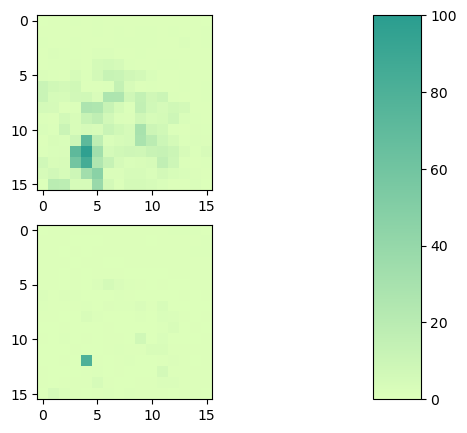

In [76]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP\\20170622_patch2.npy"
filepath_sc = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP\\20170622_patch2_sc.npy"

mtx_f1 = np.load(filepath)
mtx_f1_sc = np.load(filepath_sc)
plt.subplot(211)
plt.imshow(mtx_f1, vmin=0, vmax=100, cmap=cm)
plt.subplot(212)
plt.imshow(mtx_f1_sc, vmin=0, vmax=100, cmap=cm)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)
plt.show()

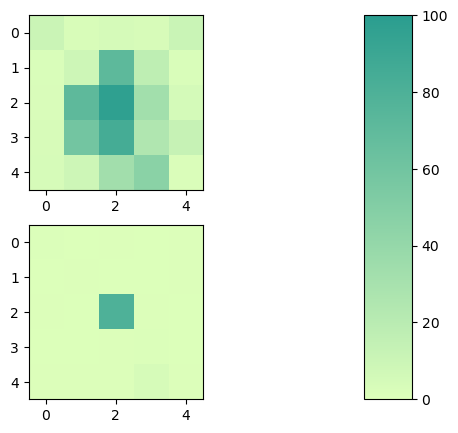

In [77]:
#Exemplary MEA Array
padded_matrix_ejemplo = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
padded_matrix_ejemplo_sc = np.pad(mtx_f1_sc.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
x, y = np.where(padded_matrix_ejemplo==np.nanmax(padded_matrix_ejemplo))
max_f_score_ejemplo = padded_matrix_ejemplo[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]
x, y = np.where(padded_matrix_ejemplo==np.nanmax(padded_matrix_ejemplo))
max_f_score_ejemplo_sc = padded_matrix_ejemplo_sc[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]
plt.subplot(211)
plt.imshow(max_f_score_ejemplo, vmin=0, vmax=100, cmap=cm)
plt.subplot(212)
plt.imshow(max_f_score_ejemplo_sc, vmin=0, vmax=100, cmap=cm)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)
plt.show()

In [78]:
dist_1 = [(2, 2)]
dist_2 = [(1, 2), (2, 1), (3, 2), (2, 3)]
dist_3 = [(1, 1), (3, 1), (1, 3), (3, 3)]
dist_4 = [(0, 2),  (2, 0), (4, 2), (2, 4)]
dist_5 = [(0, 1), (1, 0), (0, 3), (3, 0), (1, 4), (4, 1), (4, 3), (3, 4)]
dist_6 = [(0, 0), (4, 0), (0, 4), (4, 4)]
dist_tot = [dist_1, dist_2, dist_3, dist_4, dist_5, dist_6]

In [79]:
dist_ejemplo=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ejemplo[idx].append(max_f_score_ejemplo[int(j[0]), int(j[1])])
        
dist_ejemplo_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ejemplo_sc[idx].append(max_f_score_ejemplo_sc[int(j[0]), int(j[1])])

In [80]:
valores_dist_ejemplo = np.zeros(len(dist_ejemplo))
for i in range(len(dist_ejemplo)):
    aplanado = np.squeeze(dist_ejemplo[i]).flatten()
    valores_dist_ejemplo[i] = np.nanmean(aplanado)
    
valores_dist_ejemplo_sc = np.zeros(len(dist_ejemplo_sc))
for i in range(len(dist_ejemplo_sc)):
    aplanado = np.squeeze(dist_ejemplo_sc[i]).flatten()
    valores_dist_ejemplo_sc[i] = np.nanmean(aplanado)

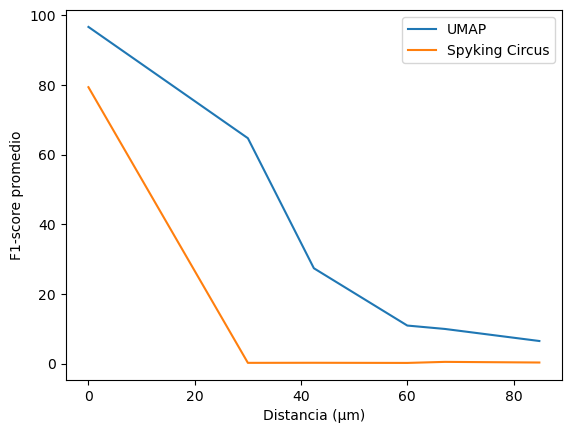

In [81]:
#Exemplary MEA Array
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.plot(x, valores_dist_ejemplo, label="UMAP")
plt.plot(x, valores_dist_ejemplo_sc, label="Spyking Circus")
plt.ylabel("F1-score promedio")
plt.xlabel("Distancia (μm)")
plt.legend()

In [24]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
archivos = np.array([file for file in os.listdir(filepath) if ((file[0] == "2"))])
f_scores_sc = []
f_scores = []
for i in archivos:
    if i[-5]=="c":
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        f_scores_sc.append(padded_matrix)  
    else:
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        f_scores.append(padded_matrix)  

In [25]:
max_f_score = np.zeros((18, 5, 5))
max_f_score_sc = np.zeros((18, 5, 5))
pos_x = []
pos_y = []
pos_x_sc = []
pos_y_sc = []
for idx, i in enumerate(f_scores):
    x, y = np.where(i==np.nanmax(i))
    pos_x.append(x)
    pos_y.append(y)
    max_f_score[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

In [26]:
for idx, i in enumerate(f_scores_sc):
    x, y = np.where(i==np.nanmax(i))
    pos_x_sc.append(x)
    pos_y_sc.append(y)
    max_f_score_sc[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

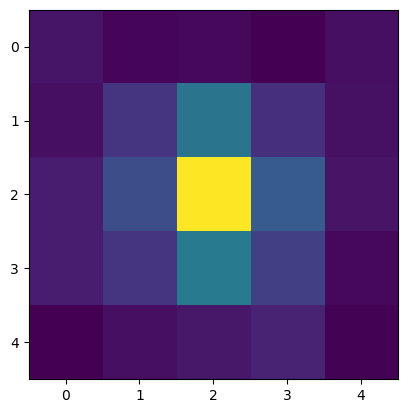

In [27]:
#Average MEA Array (UMAP)
plt.imshow(np.nanmean(max_f_score, 0))

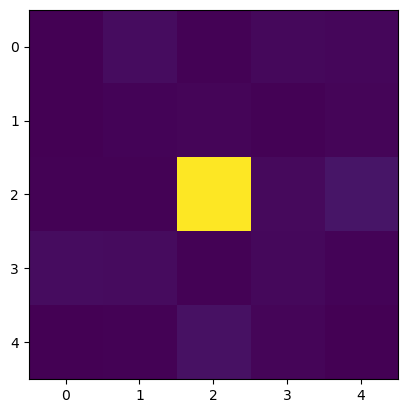

In [28]:
#Average MEA Array (SC)
plt.imshow(np.nanmean(max_f_score_sc, 0))

In [29]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
archivos = np.array([file for file in os.listdir(filepath) if ((file[0] == "3"))])
precision_scores_sc = []
precision_scores = []
for i in archivos:
    if i[-5]=="c":
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        precision_scores_sc.append(padded_matrix)  
    else:
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        precision_scores.append(padded_matrix)

In [30]:
max_precision_score = np.zeros((18, 5, 5))
max_precision_score_sc = np.zeros((18, 5, 5))
for idx, i in enumerate(precision_scores):
    x, y = pos_x[idx], pos_y[idx]
    max_precision_score[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

In [31]:
for idx, i in enumerate(precision_scores_sc):
    x, y = pos_x_sc[idx], pos_y_sc[idx]
    max_precision_score_sc[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

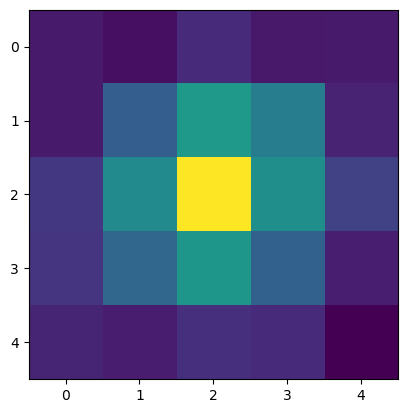

In [32]:
#Average Precision MEA Array (UMAP)
plt.imshow(np.nanmean(max_precision_score, 0))

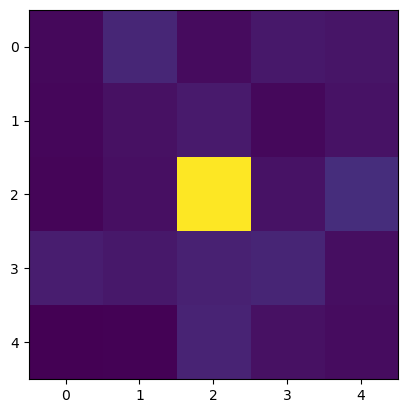

In [33]:
#Average Precision MEA Array (SC)
plt.imshow(np.nanmean(max_precision_score_sc, 0))

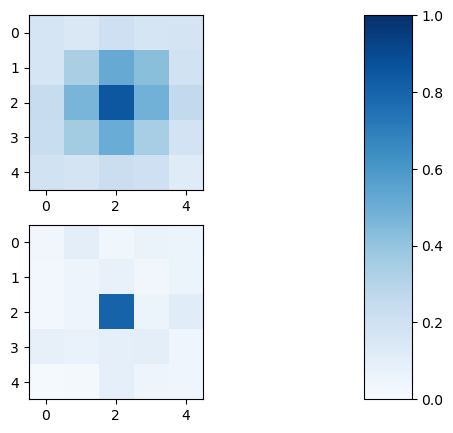

In [35]:
plt.subplot(211)
plt.imshow(np.nanmean(max_precision_score/100, 0), vmin=0, vmax=1, cmap="Blues")
plt.subplot(212)
plt.imshow(np.nanmean(max_precision_score_sc/100, 0), vmin=0, vmax=1, cmap="Blues")

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)
plt.show()

In [36]:
filepath = "C:\\Users\\RRlab_IFC_1\\Spyking Circus y UMAP"
archivos = np.array([file for file in os.listdir(filepath) if ((file[0] == "4"))])
recall_scores_sc = []
recall_scores = []
for i in archivos:
    if i[-5]=="c":
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        recall_scores_sc.append(padded_matrix)  
    else:
        doc = join(filepath, i)
        mtx_f1 = np.load(doc)
        padded_matrix = np.pad(mtx_f1.astype(float), ((2, 2), (2, 2)), mode='constant', constant_values=np.nan)
        recall_scores.append(padded_matrix)

In [37]:
max_recall_score = np.zeros((18, 5, 5))
max_recall_score_sc = np.zeros((18, 5, 5))
for idx, i in enumerate(recall_scores):
    x, y = pos_x[idx], pos_y[idx]
    max_recall_score[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

In [38]:
for idx, i in enumerate(recall_scores_sc):
    x, y = pos_x_sc[idx], pos_y_sc[idx]
    max_recall_score_sc[idx] = i[x[0] - 2:x[0] + 3, y[0] - 2:y[0] + 3]

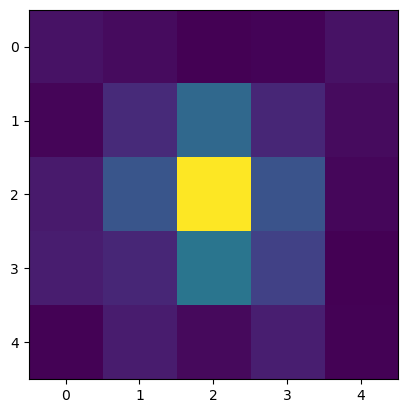

In [39]:
#Average Recall MEA Array (UMAP)
plt.imshow(np.nanmean(max_recall_score, 0))

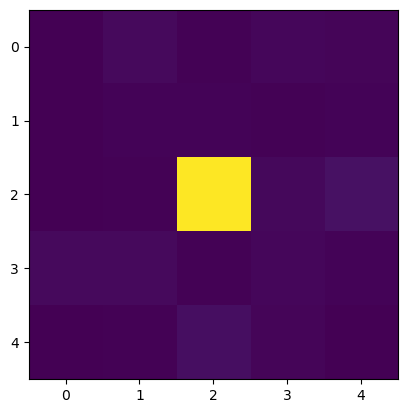

In [40]:
#Average Recall MEA Array (SC)
plt.imshow(np.nanmean(max_recall_score_sc, 0))

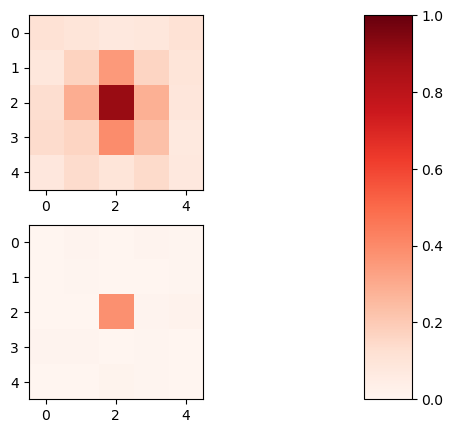

In [41]:
plt.subplot(211)
plt.imshow(np.nanmean(max_recall_score/100, 0), vmin=0, vmax=1, cmap="Reds")
plt.subplot(212)
plt.imshow(np.nanmean(max_recall_score_sc/100, 0), vmin=0, vmax=1, cmap="Reds")

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.85, 0.1, 0.075, 0.8))
plt.colorbar(cax=cax)
plt.savefig("matrices_promedio_pérdidas (recall).svg")

plt.show()

In [90]:
dist_ver_final_2024=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024[idx].append(max_f_score[:, int(j[0]), int(j[1])])

In [91]:
valores_dist = np.zeros(len(dist_ver_final_2024))
desv = np.zeros(len(dist_ver_final_2024))
for i in range(len(dist_ver_final_2024)):
    aplanado = np.squeeze(dist_ver_final_2024[i]).flatten()
    valores_dist[i] = np.nanmean(aplanado)
    desv[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

In [92]:
dist_ver_final_2024_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_sc[idx].append(max_f_score_sc[:, int(j[0]), int(j[1])])

In [93]:
valores_dist_sc = np.zeros(len(dist_ver_final_2024_sc))
desv_sc = np.zeros(len(dist_ver_final_2024_sc))
for i in range(len(dist_ver_final_2024_sc)):
    aplanado = np.squeeze(dist_ver_final_2024_sc[i]).flatten()
    valores_dist_sc[i] = np.nanmean(aplanado)
    desv_sc[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

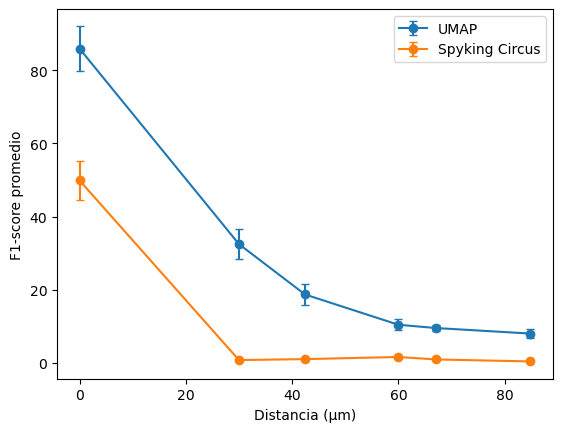

In [94]:
#Average MEA Arrays
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.errorbar(x, valores_dist, yerr=desv, marker='o', capsize=3, label="UMAP")
plt.errorbar(x, valores_dist_sc, yerr=desv_sc, marker='o', capsize=3, label="Spyking Circus")
plt.ylabel("F1-score promedio")
plt.xlabel("Distancia (μm)")
plt.legend()

In [47]:
dist_ver_final_2024_precision=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_precision[idx].append(max_precision_score[:, int(j[0]), int(j[1])])

In [48]:
valores_dist_precision = np.zeros(len(dist_ver_final_2024_precision))
desv_precision = np.zeros(len(dist_ver_final_2024_precision))
for i in range(len(dist_ver_final_2024_precision)):
    aplanado = np.squeeze(dist_ver_final_2024_precision[i]).flatten()
    valores_dist_precision[i] = np.nanmean(aplanado)
    desv_precision[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

In [49]:
dist_ver_final_2024_precision_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_precision_sc[idx].append(max_precision_score_sc[:, int(j[0]), int(j[1])])

In [50]:
valores_dist_precision_sc = np.zeros(len(dist_ver_final_2024_precision_sc))
desv_precision_sc = np.zeros(len(dist_ver_final_2024_precision_sc))
for i in range(len(dist_ver_final_2024_precision_sc)):
    aplanado = np.squeeze(dist_ver_final_2024_precision_sc[i]).flatten()
    valores_dist_precision_sc[i] = np.nanmean(aplanado)
    desv_precision_sc[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

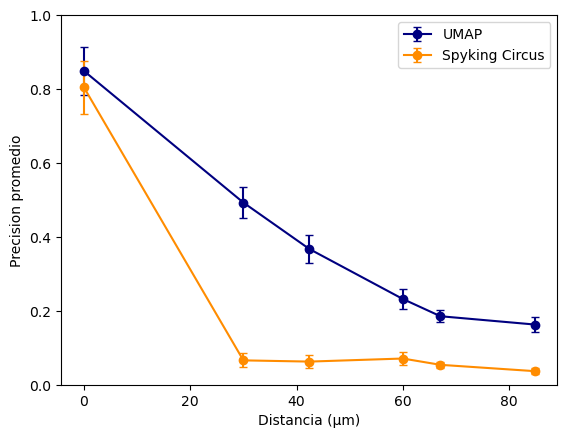

In [51]:
#Average Precision MEA Arrays
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.errorbar(x, valores_dist_precision/100, yerr=desv_precision/100, marker='o', capsize=3, label="UMAP", color="navy")
plt.errorbar(x, valores_dist_precision_sc/100, yerr=desv_precision_sc/100, marker='o', capsize=3, label="Spyking Circus", color="darkorange")
plt.ylabel("Precision promedio")
plt.xlabel("Distancia (μm)")
plt.legend()
plt.ylim(0, 1)

In [52]:
dist_ver_final_2024_recall=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_recall[idx].append(max_recall_score[:, int(j[0]), int(j[1])])

In [53]:
valores_dist_recall = np.zeros(len(dist_ver_final_2024_recall))
desv_recall = np.zeros(len(dist_ver_final_2024_recall))
for i in range(len(dist_ver_final_2024_recall)):
    aplanado = np.squeeze(dist_ver_final_2024_recall[i]).flatten()
    valores_dist_recall[i] = np.nanmean(aplanado)
    desv_recall[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

In [54]:
dist_ver_final_2024_recall_sc=[[] for i in range(len(dist_tot))]
for idx, i in enumerate(dist_tot):
    for j in i:
        dist_ver_final_2024_recall_sc[idx].append(max_recall_score_sc[:, int(j[0]), int(j[1])])

In [55]:
valores_dist_recall_sc = np.zeros(len(dist_ver_final_2024_recall_sc))
desv_recall_sc = np.zeros(len(dist_ver_final_2024_recall_sc))
for i in range(len(dist_ver_final_2024_recall_sc)):
    aplanado = np.squeeze(dist_ver_final_2024_recall_sc[i]).flatten()
    valores_dist_recall_sc[i] = np.nanmean(aplanado)
    desv_recall_sc[i] = np.nanstd(aplanado) / np.sqrt(len(aplanado) - np.count_nonzero(np.isnan(aplanado)))

(0.0, 1.0)

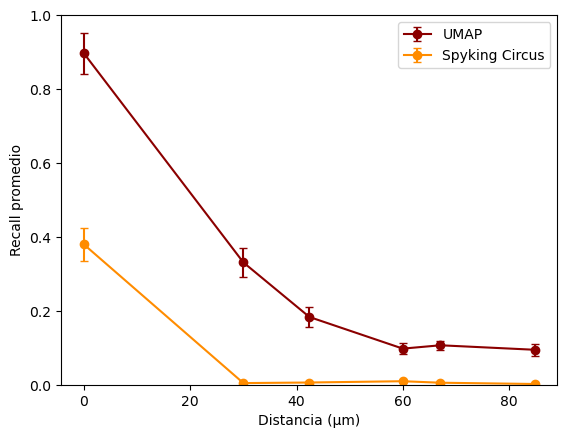

In [56]:
#Average Recall MEA Arrays
x = [0, 30, 42.42, 60, 67.08, 84.85]
plt.errorbar(x, valores_dist_recall/100, yerr=desv_recall/100, marker='o', capsize=3, label="UMAP", color="darkred")
plt.errorbar(x, valores_dist_recall_sc/100, yerr=desv_recall_sc/100, marker='o', capsize=3, label="Spyking Circus", color="darkorange")
plt.ylabel("Recall promedio")
plt.xlabel("Distancia (μm)")
plt.legend()
plt.ylim(0, 1)

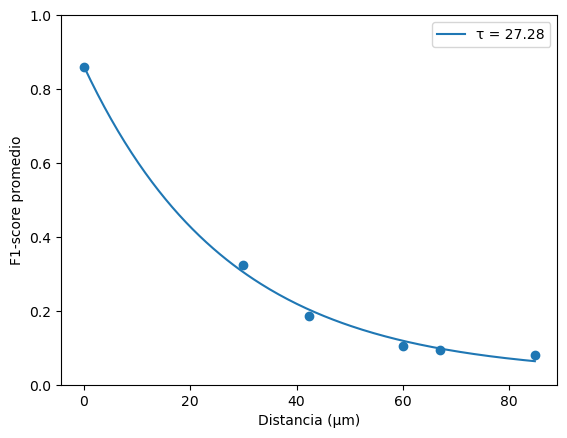

In [95]:
from scipy.optimize import least_squares
def exponencial(x, A, B, tau):
    return A*((np.exp(-(x/tau)))+B)
def residual(params, x, y):
    return exponencial(x, *params)-y
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist/100)
plt.plot(valores, ajuste/100, label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("F1-score promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

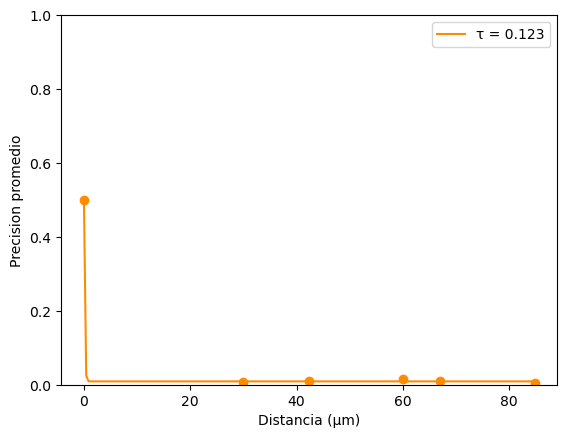

In [96]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_sc), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_sc/100, color="darkorange")
plt.plot(valores, ajuste/100, color="darkorange", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Precision promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

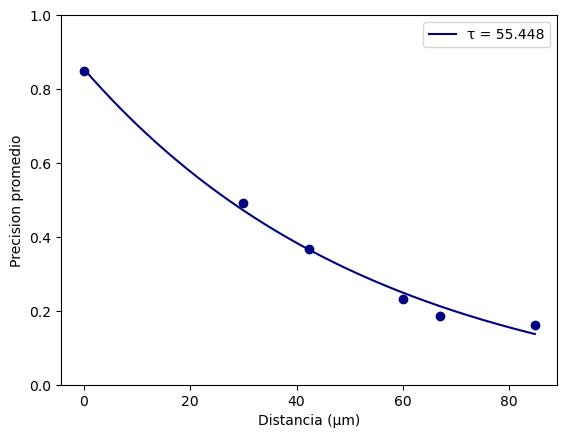

In [84]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_precision), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_precision/100, color="navy")
plt.plot(valores, ajuste/100, color="navy", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Precision promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

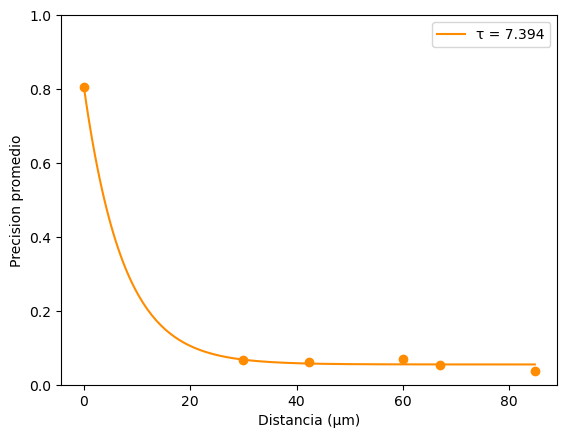

In [64]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_precision_sc), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_precision_sc/100, color="darkorange")
plt.plot(valores, ajuste/100, color="darkorange", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Precision promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

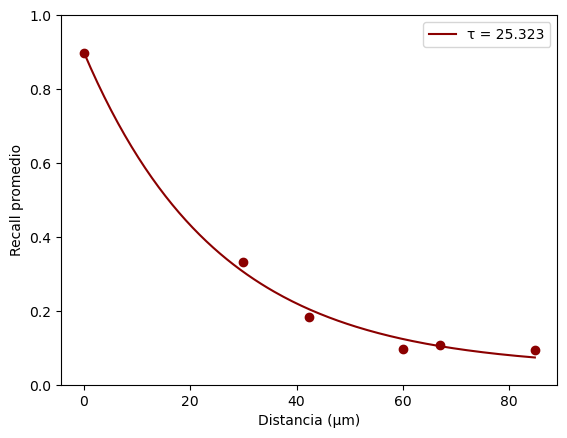

In [65]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_recall), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_recall/100, color="darkred")
plt.plot(valores, ajuste/100, color="darkred", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Recall promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()

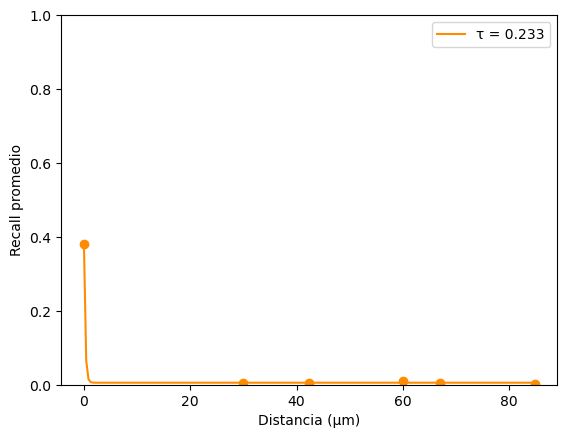

In [66]:
param_ajustados=least_squares(residual, [1, 1, 1], args=(x, valores_dist_recall_sc), jac="cs", loss="linear").x
valores=np.linspace(np.amin(x), np.amax(x), 200)
ajuste=exponencial(valores, *param_ajustados)
plt.scatter(x, valores_dist_recall_sc/100, color="darkorange")
plt.plot(valores, ajuste/100, color="darkorange", label="τ = {}".format(np.round(param_ajustados[2], 3)))
plt.xlabel("Distancia (μm)")
plt.ylabel("Recall promedio")
plt.legend()
plt.ylim(0, 1)
plt.show()